In [9]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
%matplotlib inline

In [10]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [11]:
# Initialize all necessary features
# Initialize SVM
def initialize_svm(C=0.01, gamma=0):
  svm = cv2.ml.SVM_create()
  svm.setGamma(gamma)
  svm.setC(C)
  svm.setKernel(cv2.ml.SVM_LINEAR)
  svm.setType(cv2.ml.SVM_C_SVC)
  svm.setTermCriteria((cv2.TERM_CRITERIA_EPS + 
                         cv2.TERM_CRITERIA_MAX_ITER, 
                         1000, 1e-3))

  return svm


# Train SVM on data and labels
def svm_train(svm, samples, labels):
  svm.train(samples, cv2.ml.ROW_SAMPLE, labels)


# predict labels for given samples
def predict(svm, samples):
  return svm.predict(samples)[1]

# Initialize HOG parameters
window = (64, 128)
block = (32, 32)
block_stride = (8, 8)
cell = (8, 8)
n_bins = 9
derivative_aperature = 1
sigma = -1
norm_type = 0
threshold = 0.2
gamma_correction = True
nlevels = 64
gradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(window, block, block_stride,
                      cell, n_bins,derivative_aperature,
                      sigma, norm_type, threshold, 
                      gamma_correction, nlevels,gradient)

In [12]:
# compute HOG features for given images
def get_hog_features(hog, images):
  hog_features = []
  for image in images:
    hog_feature = hog.compute(image)
    hog_features.append(hog_feature)
  return hog_features

# Convert HOG descriptors to format recognized by SVM
def prepare_for_svm(hog_features):
  featureVectorLength = len(hog_features[0])
  print("Feature vector: ", featureVectorLength)
  data = np.float32(hog_features).reshape(-1, featureVectorLength)
  print("Data: ", data.shape)
  return data

def get_svm_detector_for_hog(model_path, hog):
  svm = cv2.ml.SVM_load(model_path)
  sv = svm.getSupportVectors()
  rho,_ ,_ = svm.getDecisionFunction(0)
  svm_detector = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
  svm_detector[:-1] = -sv[:]
  svm_detector[-1] = rho
  return svm_detector


In [13]:
# Operating with images
def get_image_paths(folder, extension):
  image_paths = []
  for x in os.listdir(folder):
    x_path = os.path.join(folder, x)
    if os.path.splitext(x_path)[1] in extension:
      image_paths.append(x_path)
  return image_paths


def load_data_and_labels(folder, label):
  images = []
  labels = []
  image_paths = get_image_paths(folder, ['.jpg', '.png', '.jpeg'])
  for image_path in image_paths:
    im = cv2.imread(image_path, cv2.IMREAD_COLOR)
    images.append(im)
    labels.append(label)
  return images, labels

# Path to INRIA Person dataset
root ='INRIAPerson/'
# set Train and Test directory paths
train = os.path.join(root, 'train_64x128_H96')  # train: 'INRIAPerson/train_64x128_H96'
test = os.path.join(root, 'test_64x128_H96')  # test: 'INRIAPerson/test_64x128_H96'

In [14]:
# Turn on/off training, tFalseg, querying and retraining activities
is_train = False
is_test = True
# is_query = True
# is_retrain = True

In [15]:
# Traning for the first time
if is_train:
    train_pos = os.path.join(train, 'posPatches')
    train_neg = os.path.join(train, 'negPatches')

    train_pos_images, train_pos_labels = load_data_and_labels(train_pos, 1)
    train_neg_images, train_neg_labels = load_data_and_labels(train_neg, -1)

    train_images = np.concatenate((np.array(train_pos_images), 
                       np.array(train_neg_images)), 
                                  axis=0)
    train_labels = np.concatenate((np.array(train_pos_labels), 
                       np.array(train_neg_labels)),
                                  axis=0)

    hog_train = get_hog_features(hog, train_images)
    train_data = prepare_for_svm(hog_train)

    # Finally create an SVM object, train the model and save it.
    model = initialize_svm(C=0.01, gamma=0)
    svm_train(model, train_data, train_labels)
    model.save('pedestrian.yml')

Feature vector:  9360
Data:  (1126, 9360)
label -- 1:1063, -1:63
TP: 1063, FP: 63, Total: 1126, error: 5.595026642984014
Feature vector:  9360
Data:  (4530, 9360)
label -- 1:14, -1:4516
TN: 4516, FN: 14, Total: 4530, error: 0.3090507726269316
Precision: 94.40497335701599, Recall: 98.70009285051067


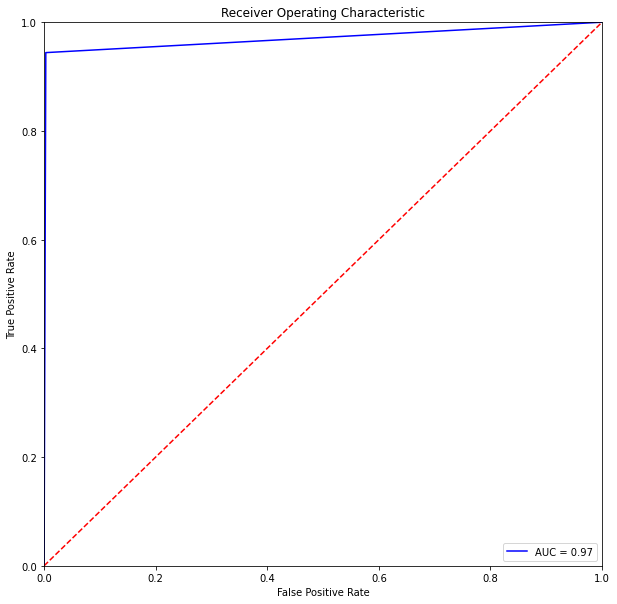

In [16]:
# Testing model with data from test set 
def evaluate(svm, samples, labels):
  labels = labels[:, np.newaxis]
  pred = svm.predict(samples)[1]
  correct = np.sum((labels == pred))
  err = (labels != pred).mean()
  print('label -- 1:{}, -1:{}'.format(np.sum(pred == 1), 
          np.sum(pred == -1)))
  return correct, err * 100, pred

if is_test:
    model = cv2.ml.SVM_load('pedestrian.yml')
    test_pos = os.path.join(test, 'posPatches')
    test_neg = os.path.join(test, 'negPatches')
    # We will follow the same flow to prepare data as we did for training images.
    # Label 1 for positive images and -1 for negative images
    test_pos_images, test_pos_labels = load_data_and_labels(test_pos, 1)
    test_neg_images, test_neg_labels = load_data_and_labels(test_neg, -1)

    # Compute HOG features for images
    hog_post_test = get_hog_features(hog, np.array(test_pos_images))
    test_pos_data = prepare_for_svm(hog_post_test)
    
    pos_correct, pos_err, pos_pred = evaluate(model, test_pos_data, 
                                       np.array(test_pos_labels))

    tp = pos_correct
    fp = len(test_pos_labels) - pos_correct
    print('TP: {}, FP: {}, Total: {}, error: {}'
            .format(tp, fp, len(test_pos_labels), pos_err))

    hog_neg_test = get_hog_features(hog, np.array(test_neg_images))
    test_neg_data = prepare_for_svm(hog_neg_test)
    neg_correct, neg_err, neg_pred = evaluate(model, test_neg_data, 
                                       np.array(test_neg_labels))

    # Calculate True and False Negatives
    tn = neg_correct
    fn = len(test_neg_data) - neg_correct
    print('TN: {}, FN: {}, Total: {}, error: {}'
            .format(tn, fn, len(test_neg_labels), neg_err))
    # Calculate Precision and Recall
    precision = tp * 100 / (tp + fp)
    recall = tp * 100 / (tp + fn)
    print('Precision: {}, Recall: {}'.format(precision, recall))

    pos_pred = [i for sublist in pos_pred.tolist() for i in sublist]
    neg_pred = [i for sublist in neg_pred.tolist() for i in sublist]
    for i in range(len(test_neg_labels)):
        test_pos_labels.append(test_neg_labels[i])
        pos_pred.append(neg_pred[i])
    test_labels = test_pos_labels
    test_pred = pos_pred

    fpr, tpr, threshold = metrics.roc_curve(test_labels, test_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')


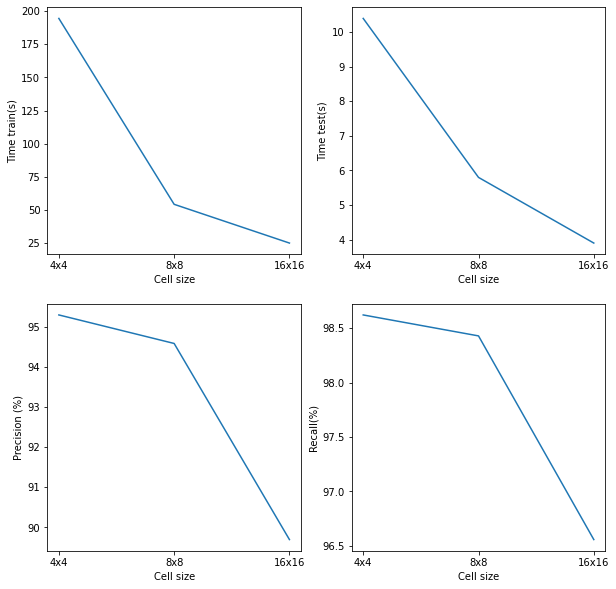

In [17]:
import pandas as pd 
import seaborn as sns
data = {'Time train': [194.5, 54.4, 25.2], 'Time test': [10.4, 5.8, 3.9], 'Precision': [95.2931, 94.5826, 89.6980
], 'Recall':[98.6213, 98.4288, 96.5583]}
df = pd.DataFrame(data, index = ['4x4', '8x8', '16x16'])  
plt.subplot(221)
plt.plot(df.index, df['Time train'])
plt.ylabel('Time train(s)')
plt.xlabel('Cell size')
plt.subplot(222)
plt.plot(df.index, df['Time test'])
plt.ylabel('Time test(s)')
plt.xlabel('Cell size')
plt.subplot(223)
plt.plot(df.index, df['Precision'])
plt.xlabel('Cell size')
plt.ylabel('Precision (%)')
plt.subplot(224)
plt.plot(df.index, df['Recall'])
plt.xlabel('Cell size')
plt.ylabel('Recall(%)')
plt.show()

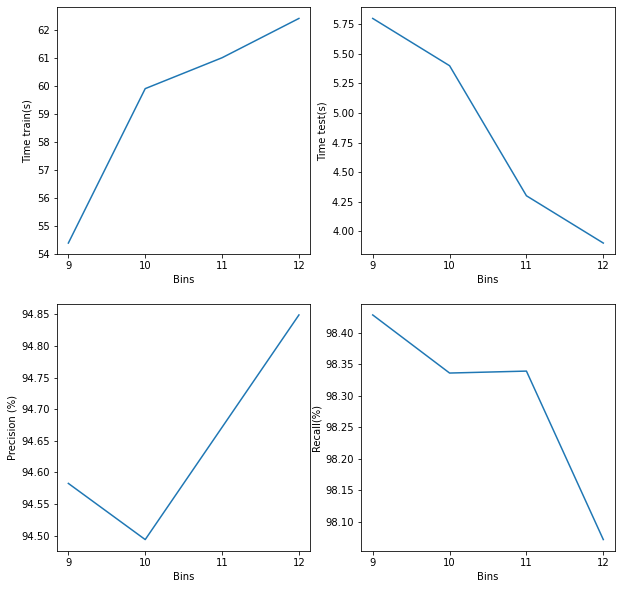

In [28]:
data2 = {'Time train': [54.4, 59.9, 61, 62.4], 'Time test': [5.8, 5.4, 4.3,3.9], 'Precision': [94.5826, 94.4938, 94.6714, 94.8490
], 'Recall':[98.4288, 98.3364, 98.3395, 98.0716]}
df = pd.DataFrame(data2, index = ['9', '10', '11', '12'])  
plt.subplot(221)
plt.plot(df.index, df['Time train'])
plt.ylabel('Time train(s)')
plt.xlabel('Bins')
plt.subplot(222)
plt.plot(df.index, df['Time test'])
plt.ylabel('Time test(s)')
plt.xlabel('Bins')
plt.subplot(223)
plt.plot(df.index, df['Precision'])
plt.xlabel('Bins')
plt.ylabel('Precision (%)')
plt.subplot(224)
plt.plot(df.index, df['Recall'])
plt.xlabel('Bins')
plt.ylabel('Recall(%)')
plt.show()

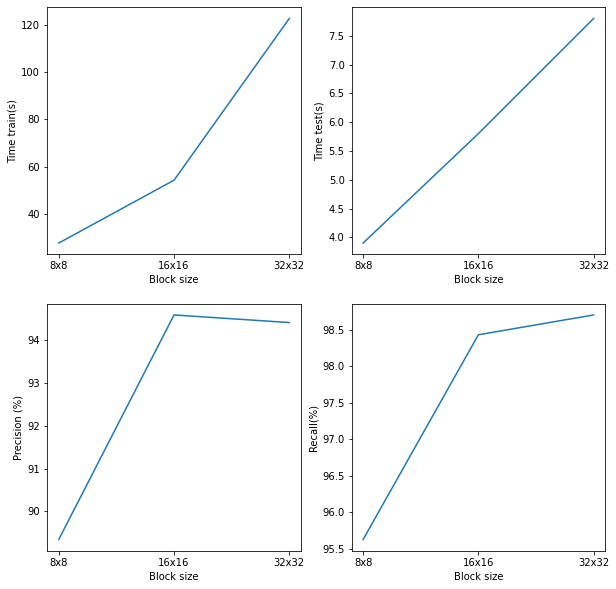

In [29]:
data3 = {'Time train': [27.9, 54.4, 122.6], 'Time test': [3.9, 5.8, 7.8], 'Precision': [89.3428, 94.5826, 94.4050
], 'Recall':[95.6274, 98.4288, 98.7001]}
df = pd.DataFrame(data3, index = ['8x8', '16x16', '32x32'])  
plt.subplot(221)
plt.plot(df.index, df['Time train'])
plt.ylabel('Time train(s)')
plt.xlabel('Block size')
plt.subplot(222)
plt.plot(df.index, df['Time test'])
plt.ylabel('Time test(s)')
plt.xlabel('Block size')
plt.subplot(223)
plt.plot(df.index, df['Precision'])
plt.xlabel('Block size')
plt.ylabel('Precision (%)')
plt.subplot(224)
plt.plot(df.index, df['Recall'])
plt.xlabel('Block size')
plt.ylabel('Recall(%)')
plt.show()

In [19]:
# # Initialize HOG once again
# window = (64, 128)
# block = (16, 16)
# block_stride = (8, 8)
# cell = (8, 8)
# n_bins = 9
# derivative_aperature = 1
# sigma = -1
# norm_type = 0
# threshold = 0.2
# gamma_correction = True
# nlevels = 64
# gradient = False

# hog = cv2.HOGDescriptor(window, block, block_stride,
#                       cell, n_bins,derivative_aperature,
#                       sigma, norm_type, threshold, 
#                       gamma_correction, nlevels,gradient)
# svm_detector = get_svm_detector_for_hog('pedestrian.yml', hog)
# hog.setSVMDetector(svm_detector)
# # Initialize HOG from lib
# hog_lib = cv2.HOGDescriptor(window, block, block_stride,
#                       cell, n_bins,derivative_aperature,
#                       sigma, norm_type, threshold, 
#                       gamma_correction, nlevels,gradient)
# svm_detector_default = cv2.HOGDescriptor_getDefaultPeopleDetector()
# hog_lib.setSVMDetector(svm_detector_default)

In [20]:
# def non_max_suppression_fast(boxes, overlapThresh):
# 	# if there are no boxes, return an empty list
# 	if len(boxes) == 0:
# 		return []
# 	# if the bounding boxes integers, convert them to floats --
# 	# this is important since we'll be doing a bunch of divisions
# 	if boxes.dtype.kind == "i":
# 		boxes = boxes.astype("float")
# 	# initialize the list of picked indexes	
# 	pick = []
# 	# grab the coordinates of the bounding boxes
# 	x1 = boxes[:,0]
# 	y1 = boxes[:,1]
# 	x2 = boxes[:,2]
# 	y2 = boxes[:,3]
# 	# compute the area of the bounding boxes and sort the bounding
# 	# boxes by the bottom-right y-coordinate of the bounding box
# 	area = (x2 - x1 + 1) * (y2 - y1 + 1)
# 	idxs = np.argsort(y2)
# 	# keep looping while some indexes still remain in the indexes
# 	# list
# 	while len(idxs) > 0:
# 		# grab the last index in the indexes list and add the
# 		# index value to the list of picked indexes
# 		last = len(idxs) - 1
# 		i = idxs[last]
# 		pick.append(i)
# 		# find the largest (x, y) coordinates for the start of
# 		# the bounding box and the smallest (x, y) coordinates
# 		# for the end of the bounding box
# 		xx1 = np.maximum(x1[i], x1[idxs[:last]])
# 		yy1 = np.maximum(y1[i], y1[idxs[:last]])
# 		xx2 = np.minimum(x2[i], x2[idxs[:last]])
# 		yy2 = np.minimum(y2[i], y2[idxs[:last]])
# 		# compute the width and height of the bounding box
# 		w = np.maximum(0, xx2 - xx1 + 1)
# 		h = np.maximum(0, yy2 - yy1 + 1)
# 		# compute the ratio of overlap
# 		overlap = (w * h) / area[idxs[:last]]
# 		# delete all indexes from the index list that have
# 		idxs = np.delete(idxs, np.concatenate(([last],
# 			np.where(overlap > overlapThresh)[0])))
# 	# return only the bounding boxes that were picked using the
# 	# integer data type
# 	return boxes[pick].astype("int")

In [21]:
# imageDir = 'Data'
# # image_paths = glob.glob(os.path.join(imageDir, '*.jpg'))
# image_paths = get_image_paths('/home/hoang/Documents/ComputerVision/Project/Data', ['.jpg', '.png', '.jpeg'])
# finalHeight = 800.0

# for imagePath in image_paths:
#     print('processing: {}'.format(imagePath))
#     im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
#     scale = finalHeight / im.shape[0]
#     im = cv2.resize(im, None, fx=scale, fy=scale)
    
#     bboxes, weights = hog.detectMultiScale(im, winStride=(8, 8),
#                                     padding=(32, 32),scale=1.05, 
#                                     finalThreshold=2,hitThreshold=1.0)

#     bboxes2, weights2 = hog_lib.detectMultiScale(im, winStride=(8, 8), 
#                                 padding=(32, 32),scale=1.05, 
#                                 finalThreshold=2,hitThreshold=0)
    
#     if len(bboxes) > 0:
#         print('Trained Detector :: pedestrians detected: {}'
#                 .format(bboxes.shape[0]))
#     if len(bboxes2) > 0:
#         print('Default Detector :: pedestrians detected: {}'
#                 .format(bboxes2.shape[0]))
    
#     for bbox in bboxes:
#         x1, y1, w, h = bbox
#         x2, y2 = x1 + w, y1 + h
#         cv2.rectangle(im, (x1, y1), (x2, y2), 
#                       (0, 255, 0), thickness=3, 
#                       lineType=cv2.LINE_AA)

#     for bbox in bboxes2:
#         x1, y1, w, h = bbox
#         x2, y2 = x1 + w, y1 + h
#         cv2.rectangle(im, (x1, y1), (x2, y2), 
#                       (0, 0, 255), thickness=3, 
#                       lineType=cv2.LINE_AA)
                      
#     plt.imshow(im[:,:,::-1])
#     # Write image to disk
#     # imResultPath = os.path.join('results', os.path.basename(imagePath))
#     # cv2.imwrite(imResultPath, im)
#     plt.show()

In [22]:
# def getHardExamples(negImageList, hog_descriptor):
#     hardNegList = []
#     hog_descriptor.setSVMDetector(get_svm_detector_for_hog('pedestrian.yml', hog_descriptor))

#     for i in range(len(negImageList)):
#         bboxes_hard, _ = hog.detectMultiScale(negImageList[i], winStride=(8, 8),
#                                     padding=(32, 32),scale=1.05, 
#                                     finalThreshold=2,hitThreshold=1.0)
#         for (x,y,w,h) in bboxes_hard:
#             hardExample = negImageList[i][y:y+h, x:x+w]
#             hardNegList.append(cv2.resize(hardExample,(64,128)))

#     return hardNegList

In [23]:
# window = (64, 128)
# block = (16, 16)
# block_stride = (8, 8)
# cell = (8, 8)
# n_bins = 9
# derivative_aperature = 1
# sigma = -1
# norm_type = 0
# threshold = 0.2
# gamma_correction = True
# nlevels = 64
# gradient = False

# hog_retrain = cv2.HOGDescriptor(window, block, block_stride,
#                         cell, n_bins, derivative_aperature,
#                         sigma, norm_type, threshold,
#                         gamma_correction, nlevels, gradient)

In [24]:
# train = os.path.join(root, 'train_64x128_H96')
# train_pos = os.path.join(train, 'posPatches')
# train_neg = os.path.join(train, 'negPatches')
# train_pos_images, train_pos_labels = load_data_and_labels(train_pos, 1)
# train_neg_images, train_neg_labels = load_data_and_labels(train_neg, -1)
# train_images = np.concatenate((np.array(train_pos_images), 
#                     np.array(train_neg_images)), 
#                                 axis=0)
# train_labels = np.concatenate((np.array(train_pos_labels), 
#                     np.array(train_neg_labels)),
#                                 axis=0)

In [25]:
# if is_retrain:
#     print("Start loading images from other source")
#     negImages = []
#     for i in os.listdir('13_Natural_Scene'):
#         images, train_neg_labels = load_data_and_labels(os.path.join('13_Natural_Scene', i), -1)
#         for image in images:
#             negImages.append(image)
#     # images, train_neg_labels = load_data_and_labels('INRIAPerson/train_64x128_H96/negPatches', -1)
#     for image in images:
#         negImages.append(image)
#     print("Finish loading, get hard negative images")                      
#     hardNegListImages = getHardExamples(negImages, hog_retrain)
#     hardNegLabels = [-1 for i in range(len(hardNegListImages))]
#     retrain_images = np.concatenate((np.array(train_images), 
#                     np.array(hardNegListImages)), 
#                                 axis=0)
#     retrain_labels = np.concatenate((np.array(train_labels), 
#                         np.array(hardNegLabels)),
#                                     axis=0)
#     hog_retrain_features = get_hog_features(hog_retrain, retrain_images)
#     retrain_data = prepare_for_svm(hog_retrain_features)
#     model = initialize_svm(C=0.01, gamma=0)
#     print("Retraining the model")
#     svm_train(model, retrain_data, retrain_labels)
#     model.save('pedestrian2.pt')

In [26]:
# svm_detector = get_svm_detector_for_hog('pedestrian2.pt', hog)
# hog.setSVMDetector(svm_detector)

In [27]:
# # read images from pedestrians directory
# imageDir = 'Data'
# image_paths = get_image_paths('/home/hoang/Documents/ComputerVision/Project/Data', ['.jpg', '.png', '.jpeg'])
# finalHeight = 800.0

# for imagePath in image_paths:
#     print('processing: {}'.format(imagePath))
#     im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
#     scale = finalHeight / im.shape[0]
#     im = cv2.resize(im, None, fx=scale, fy=scale)
    
#     bboxes, weights = hog.detectMultiScale(im, winStride=(8, 8),
#                                     padding=(32, 32),scale=1.05, 
#                                     finalThreshold=2,hitThreshold=1.0)

#     # detectMultiScale using default detector
#     bboxes2, weights2 = hog_lib.detectMultiScale(im, winStride=(8, 8), 
#                                 padding=(32, 32),scale=1.05, 
#                                 finalThreshold=2,hitThreshold=0)
    
#     if len(bboxes) > 0:
#         print('Trained Detector :: pedestrians detected: {}'
#                 .format(bboxes.shape[0]))
#     if len(bboxes2) > 0:
#         print('Default Detector :: pedestrians detected: {}'
#                 .format(bboxes2.shape[0]))

#     for bbox in bboxes:
#         x1, y1, w, h = bbox
#         x2, y2 = x1 + w, y1 + h
#         cv2.rectangle(im, (x1, y1), (x2, y2), 
#                       (0, 255, 0), thickness=3, 
#                       lineType=cv2.LINE_AA)

#     for bbox in bboxes2:
#         x1, y1, w, h = bbox
#         x2, y2 = x1 + w, y1 + h
#         cv2.rectangle(im, (x1, y1), (x2, y2), 
#                       (0, 0, 255), thickness=3, 
#                       lineType=cv2.LINE_AA)

#     plt.imshow(im[:,:,::-1])
#     # Write image to disk
#     # imResultPath = os.path.join('results', os.path.basename(imagePath))
#     # cv2.imwrite(imResultPath, im)
#     plt.show()